In [16]:
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

In [6]:
class JSONLDataset(Dataset):
    def __init__(self, file_path, ul2=False,max_text_len = 200, max_block_size = 100):
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token_id = 50256
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        self.path = file_path
        self.max_length = max_length - 1
        self.max_block_size = max_block_size
        self.vocab_size = len(self.tokenizer)
        
        x = []
        y = []
        f = open(file_path,'r')
        lines = f.readlines()

        if ul2 == False:
            for line in lines:
                item = json.loads(line)['text'][:max_text_len]
                
                if len(item) <= max_text_len:
                    item = self.tokenizer(item, padding='max_length',max_length=max_block_size, truncation=True,return_tensors='pt')["input_ids"][0]

                    x.append(item[:-1])
                    y.append(item[1:])

            self.x = x
            self.y = y
        else:
            for line in lines:
                item = json.loads(line)['text'][:10]
                item = self.tokenizer(item, padding='max_length',max_length=max_block_size, truncation=True,return_tensors='pt')["input_ids"][0]
                # just drop if too big
                if len(item) > self.max_length:
                    continue
                x.append(item[:-1])
                y.append(item[1:])

            self.x = x
            self.y = y
            
    
    def get_vocab_size(self):
        return self.vocab_size
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.max_block_size * 2 -1
                    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x,y


In [8]:
dataset = JSONLDataset("proj2_data.jsonl")

In [10]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = dataset.get_vocab_size()
model_config.block_size = dataset.get_block_size()
model_config.checkpoint = None
model = GPT(model_config)

number of parameters: 2.51M


In [13]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 200
train_config.num_workers = 0
trainer = Trainer(train_config, model, dataset)

running on device cpu


In [14]:
loss = []
def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        loss.append(trainer.loss.item())
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 9.84522
iter_dt 2186.88ms; iter 10: train loss 9.40946
iter_dt 2191.79ms; iter 20: train loss 8.93967
iter_dt 2255.17ms; iter 30: train loss 8.45746
iter_dt 2354.24ms; iter 40: train loss 7.95766
iter_dt 2220.96ms; iter 50: train loss 7.44101
iter_dt 2175.94ms; iter 60: train loss 6.91157
iter_dt 2204.47ms; iter 70: train loss 6.37363
iter_dt 2231.80ms; iter 80: train loss 5.83111
iter_dt 2216.81ms; iter 90: train loss 5.28708
iter_dt 2234.98ms; iter 100: train loss 4.73242
iter_dt 2236.42ms; iter 110: train loss 4.15990
iter_dt 2211.72ms; iter 120: train loss 3.62280
iter_dt 2170.20ms; iter 130: train loss 3.05202
iter_dt 2254.68ms; iter 140: train loss 2.51689
iter_dt 2203.02ms; iter 150: train loss 1.97902
iter_dt 2189.21ms; iter 160: train loss 1.52077
iter_dt 2199.71ms; iter 170: train loss 1.11712
iter_dt 2429.09ms; iter 180: train loss 0.76470
iter_dt 2430.17ms; iter 190: train loss 0.56944


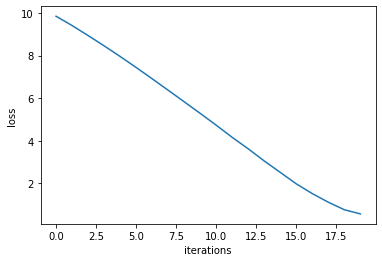

In [17]:
plt.plot(loss)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.show()